In [2]:
# Import packages
from dash import Dash, html, dcc, callback, Output, Input
import pandas as pd
import plotly.express as px
import dash_bootstrap_components as dbc

from os import listdir
from os.path import isfile, join
import numpy as np
from functools import reduce

In [4]:
# Incorporate data
path = './data/20241215'
#path = '/home/kas/Projects/Ni_project/exp_data_paper/20240524_YaoYang/'
onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.csv')]
exp_data_all = []
E_all = []
order_all = []
theta_all = []

for file in onlyfiles_keys:
    file_path = join(path, file)
    df = pd.read_csv(file_path)#.groupby('file_list', as_index=False)
    df['file_name'] = file  # Add the file name column
    file_uni = np.unique(df['file_list'])
    # Iterate over each unique 'file_list' value
    for f in file_uni:
        # Create a mask for the current 'file_list' value
        mask = df['file_list'] == f
        
        # Normalize 'order_list' for the current 'file_list' value by the value where 'order_list' is 1
        norm_value = df.loc[mask & (df['order_list'] == 1), 'intensity_list'].values[0]
        df.loc[mask, 'normalized_intensity_list'] = df.loc[mask, 'intensity_list'] / norm_value

    theta_all.append(np.unique(df['theta_list']))
    order_all.append(np.unique(df['order_list']))
    E_all.append(np.unique(df['energy_list']))
    exp_data_all.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(exp_data_all, ignore_index=True)

# Unique values for orders, energies, and thetas
orders = np.unique(np.concatenate(order_all))
energies = np.unique(np.concatenate(E_all))
thetas = np.unique(np.concatenate(theta_all))

# Print the combined DataFrame
combined_df


,Unnamed: 0,order_list,energy_list,theta_list,file_list,intensity_list,x_list,y_list,file_name,normalized_intensity_list
0,0,-4,280.0,-95.0,Captured Image 1215115332.fits,34.579377,535.0,47.0,F0072_latent_L.csv,0.017313
1,1,-4,280.0,-90.0,Captured Image 1215114933.fits,30.513297,534.0,50.0,F0072_latent_L.csv,0.015892
2,2,-4,280.0,-80.0,Captured Image 1215120006.fits,28.282794,533.0,31.0,F0072_latent_L.csv,0.013994
3,3,-4,280.0,-75.0,Captured Image 1215120108.fits,26.688761,531.0,13.0,F0072_latent_L.csv,0.012388
4,4,-4,285.2,-95.0,Captured Image 1215115245.fits,185.607493,535.0,61.0,F0072_latent_L.csv,0.371114
...,...,...,...,...,...,...,...,...,...,...
3582,270,4,288.6,-85.0,Captured Image 1215130411.fits,27516.844448,549.0,970.0,F0074_dvlp_L.csv,0.051783
3583,271,4,288.6,-80.0,Captured Image 1215130449.fits,26284.403247,549.0,970.0,F0074_dvlp_L.csv,0.050581
3584,272,4,288.6,-75.0,Captured Image 1215130906.fits,20757.981767,550.0,975.0,F0074_dvlp_L.csv,0.041760
3585,273,4,288.6,-70.0,Captured Image 1215131018.fits,13259.771750,551.0,983.0,F0074_dvlp_L.csv,0.028319


In [5]:
def update_graph(entry, order,scale,norm):
    df_list = []
    names = []
    for i in entry:
        e_uni_temp = np.unique(exp_data_all[i]['energy_list'])
        for o in order:
            for e in e_uni_temp:
                mask = (exp_data_all[i]['order_list'] == o) & (exp_data_all[i]['energy_list'] == e)
                name = onlyfiles_keys[i] + ' ' + str(o)+ ' ' + str(e)
                if norm:
                    df_list.append(exp_data_all[i][['theta_list', 'normalized_intensity_list']][mask].rename(columns={'normalized_intensity_list': name}))
                else:
                    df_list.append(exp_data_all[i][['theta_list', 'intensity_list']][mask].rename(columns={'intensity_list': name}))
                names.append(name)
    
    df = reduce(lambda x, y: x.merge(y, on='theta_list', how='outer'), df_list)
    #fig = px.scatter(df, x='theta_list', y=names)
    #fig.update_xaxes(range=[np.min(thetas)-0.5, np.max(thetas)+0.5])
    #fig.update_layout( yaxis_type=scale)
    return df #fig

In [13]:
def update_graph(entry, order, scale, norm):
    filtered_df = combined_df[combined_df['file_name'].isin(entry) & combined_df['order_list'].isin(order)]
    
    #if norm:
    #    value_column = 'normalized_intensity_list'
    #else:
    #    value_column = 'intensity_list'
    
    #pivot_df = filtered_df.pivot_table(
    #    index='theta_list',
    #    columns=['file_name', 'order_list', 'energy_list'],
    #   values=value_column,
    #    aggfunc='first'
    #).reset_index()
    #print(pivot_df.columns.levels[1:])
    ## Flatten the multi-level column index
    #pivot_df.columns = ['theta_list'] + [
    #    f"{file_name} {o} {e}" for file_name, o, e in pivot_df.columns.levels[1:]
    #
    
    #fig = px.scatter(pivot_df, x='theta_list', y=pivot_df.columns[1:])
    #fig.update_xaxes(range=[np.min(thetas)-0.5, np.max(thetas)+0.5])
    #fig.update_layout(yaxis_type=scale)
    return filtered_df #fig


In [32]:
#import plotly.express as px

def update_graph(entry, order, scale, norm):
    files = [onlyfiles_keys[i] for i in entry]
    filtered_df = combined_df[combined_df['file_name'].isin(files) & combined_df['order_list'].isin(order)]
    
    if norm:
        value_column = 'normalized_intensity_list'
    else:
        value_column = 'intensity_list'
    
    filtered_df['label'] = filtered_df.apply(lambda row: f"{row['order_list']} {row['file_name']} {row['energy_list']}", axis=1)
    
    fig = px.scatter(filtered_df, x='theta_list', y=value_column, color='label')
    fig.update_xaxes(range=[np.min(thetas)-0.5, np.max(thetas)+0.5])
    fig.update_layout(yaxis_type=scale)
    
    fig.show()

# Example usage
#update_graph(['file1.csv', 'file2.csv'], [1, 2], 'linear', True)


In [33]:
entry = [1,2,3] #[1,2,3]
order = orders[:3]
scale = 'linear'
norm = False
filtered_df = update_graph(entry, order,scale,norm)

/tmp/ipykernel_372232/2384604442.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



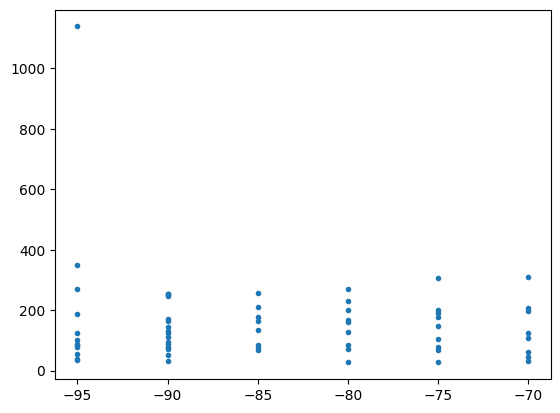

In [22]:
import matplotlib.pyplot as plt
plt.plot(filtered_df['theta_list'],filtered_df['intensity_list'],'.')

In [4]:
exp_data_all[0]

,Unnamed: 0,order_list,energy_list,theta_list,file_list,intensity_list,x_list,y_list,normalized_intensity_list
0,0,-4,280.0,-95.0,Captured Image 1215115332.fits,34.579377,535.0,47.0,0.017313
1,1,-4,280.0,-90.0,Captured Image 1215114933.fits,30.513297,534.0,50.0,0.015892
2,2,-4,280.0,-80.0,Captured Image 1215120006.fits,28.282794,533.0,31.0,0.013994
3,3,-4,280.0,-75.0,Captured Image 1215120108.fits,26.688761,531.0,13.0,0.012388
4,4,-4,285.2,-95.0,Captured Image 1215115245.fits,185.607493,535.0,61.0,0.371114
...,...,...,...,...,...,...,...,...,...
162,162,4,288.6,-90.0,Captured Image 1215120650.fits,75.415288,534.0,974.0,0.021259
163,163,4,288.6,-85.0,Captured Image 1215115754.fits,90.312727,535.0,972.0,0.021848
164,164,4,288.6,-80.0,Captured Image 1215115840.fits,88.246802,535.0,972.0,0.018124
165,165,4,288.6,-75.0,Captured Image 1215120226.fits,87.990929,536.0,976.0,0.017042
